# Classroom 3 - Working with word embeddings

So far we've seen a couple of key Python libraries for doing specific tasks in NLP. For example, ```scikit-learn``` provides a whole host of fundamental machine learning algortithms; ```spaCy``` allows us to do robust linguistic analysis; ```huggingface``` is the place to go for pretrained models (more on that in coming weeks); ```pytorch``` is the best framework for building complex deep learning models.

Today, we're going to meet ```gensim``` which is the best way to work with (static) word embeddings like word2vec. You can find the documentation [here](https://radimrehurek.com/gensim/).

In [1]:
import gensim
import gensim.downloader
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [ ]:
gensim.__version__ # 4.3.2


In [ ]:
!pip install gensim==4.2.0

## Choose a language

I've downloaded a number of pretrained word2vec models for different languages. Feel free to experiment with a couple (or with other models, if you want to download more: you can also download FastText embeddings: https://fasttext.cc/), but make sure to use different variable names for the models.

NB: The English embeddings are 300d; all other word2vec models here are 100d. Notice also that different word2vec models are loaded in different ways. This is due to way that they were saved after training - the saved formats are not consistently the same.

**Note**: depending on where your notebook is located, you may need to change the paths!

In [2]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# Danish embeddings https://korpus.dsl.dk/resources/details/word2vec.html
model_da = gensim.models.KeyedVectors.load_word2vec_format("/work/819739/models/danish.bin", binary=True)

# Polish embeddings https://github.com/sdadas/polish-nlp-resources#word2vec
#model = gensim.models.KeyedVectors.load("models/polish/model.bin")

# English embeddings http://vectors.nlpl.eu/repository/ (English CoNLL17 corpus)
model = gensim.models.KeyedVectors.load_word2vec_format("/work/819739/models/english/model.bin", binary=True)
#model_wiki = gensim.models.KeyedVectors.load_word2vec_format('glove-wiki-gigaword-300', binary=True)

I've outlined a couple of tasks for you below to experiment with. Use these just a stepping off points to explore the nature of word embeddings and how they work.

Work in small groups on these tasks and make sure to discuss the issues and compare results - preferably across languages!

### Task 1: Finding polysemy

Find a polysemous word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from both meanings. An example is given for you below in English. 

Are there certain words for which polysemy is more of a problem?
**Answer**: 

In [4]:
model_da.most_similar("dato")

[('datoen', 0.5436914563179016),
 ('fødselsdagenjubilæet', 0.5028533935546875),
 ('overskriftpå', 0.49480125308036804),
 ('datoer', 0.4871586561203003),
 ('udgivelsesdato', 0.47484177350997925),
 ('startdato', 0.47106754779815674),
 ('slutdato', 0.47075560688972473),
 ('26102010', 0.4684144854545593),
 ('premieredato', 0.4683648943901062),
 ('angivelse', 0.466962993144989)]

In [6]:
# date 
# terminal
# sexy
model.most_similar("woman")

[('woman.', 0.8146826028823853),
 ('woman.the', 0.8100795745849609),
 ('man', 0.8036593198776245),
 ('woman—and', 0.8008183836936951),
 ('prostitute', 0.7999100089073181),
 ('girl', 0.7932665944099426),
 ('menbe', 0.7846909165382385),
 ('-ager', 0.7846159934997559),
 ('awoman', 0.7812705636024475),
 ('boyfriend.the', 0.7776606678962708)]

### Task 2: Synonyms and antonyms

In the lecture, we saw that _cosine similarity_ can also be thought of as _cosine distance_, which is simply ```1 - cosine similarity```. So the higher the cosine distance, the further away two words are from each other and so they have less "in common".

Find three words ```(w1,w2,w3)``` where ```w1``` and ```w2``` are synonyms and ```w1``` and ```w3``` are antonyms, but where: 

```Cosine Distance(w1,w3) < Cosine Distance(w1,w2)```

For example, w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened. Are there any inconsistencies?

You should use the the ```model.distance(w1, w2)``` function here in order to compute the cosine distance between two words. I've given a starting example below.

In [7]:
model.distance("happy", "sad") # w1, w3, antonyms

0.3010486960411072

In [8]:
model.distance("happy","cheerful") # w1, 23

0.2960309386253357

In [7]:
model.distance("happy", "sad") < model.distance("happy","cheerful")

False

In [9]:
gensim.__version__ # 4.2.0, correct 

'4.2.0'

Similarity of antonyms *should* be 0, as their vectors are onthogonal (90 degrees) and cos(90) = 0. Distance should be 1 - the similarity. 

`word2vec` doesn't register that they are synonyms and antonyms.
The cosine similarity of 0.29 suggests that they are somewhat related, but it's not extremely high, possibly because their usage in different contexts or with different collocates may vary.

**the words must appear in somewhat similar contexts** - the algorithm looks at the context and doesn't understand the real meaning

Again, this is because Word2Vec is based on word co-occurrence patterns in the corpus, and it may not capture the strict antonymy of words like "happy" and "sad." There might be some contexts in which they appear together or in similar contexts that reduce their cosine distance.


**What data is it trained on?**: Is it science articles, news articles? Sometimes similarities calculated like this reflects semantic similarity, other times just syntactic properties similarity (they tend to occur in the same context). This model is provided from wiki data and common-crawl (they were provided this training data). Common-crawl contains a lot of trash from the web. 


### Task 3: Word analogies

We saw in the lecture on Wednesday that we can use basic arithmetic on word embeddings, in order to conduct word analogy task.

For example:

```man::king as woman::queen```

So we can say that if we take the vector for ```king``` and subtract the vector for ```man```, we're removing the gender component from the ```king```. If we then add ```woman``` to the resulting vector, we should be left with a vector similar to ```queen```.

NB: It might not be _exactly_ the vector for ```queen```, but it should at least be _close_ to it.

```gensim``` has some quirky syntax that allows us to perform this kind of arithmetic.

In [9]:
model.most_similar(positive=['king', 'woman'], 
                   negative=['man'])[0]

('queen', 0.8487650752067566)

Try to find at least three analogies which correctly hold - where "correctly" here means that the closest vector corresponds to the word that you as a native speaker think it should.

In [40]:
model.most_similar(positive=['man', 'vagina'], 
                   negative=['penis'])[0]

('woman', 0.7955009937286377)

In [10]:
model.most_similar(positive=['america', 'euro'], 
                   negative=['dollar'])[0]

('europe', 0.7367792725563049)

In [11]:
model.most_similar(positive=['widow', 'woman'], 
                   negative=['man'])[0]

('widower', 0.764756977558136)

### Task 3b: Wrong analogies

Can you find any analogies which _should_ hold but don't? Why don't they work? Are there any similarities or trends?

In [14]:
# if you subtract the coordinates of the vector man, from the coordinates of the vector president, you remove the gender component. 
# so we subtract the coordinates of the vectors (in a multidimensional space)
# then we add the vector woman to the resulting vector (president - man) and see what word is most similar

model.most_similar(positive=['president', 'woman'], 
                   negative=['man'])[0] 

('chairwoman', 0.7523451447486877)

In [55]:
model.most_similar(positive=['boss', 'woman'], 
                   negative=['man'])[0]

('boyfriend', 0.7323639392852783)

In [17]:
model.most_similar(positive=['boss', 'man'], 
                   negative=['woman'])

[('joker', 0.6831283569335938),
 ('mandroid', 0.674273669719696),
 ('m.o.d.o.k', 0.671761691570282),
 ('villian', 0.6715127825737),
 ('baddie', 0.6702835559844971),
 ('enforcer', 0.6693328022956848),
 ('bosses', 0.6671220660209656),
 ('arch-nemesis', 0.6660395860671997),
 ('verminator', 0.6652374267578125),
 ('archnemesis', 0.6638512015342712)]

In [56]:
model.most_similar(positive=['doctor', 'woman'], 
                   negative=['man'])[0]

('-midwife', 0.7573870420455933)

model.most_similar(positive=['widow', 'woman'], 
                   negative=['man'])[0]

### Task 4: Exploring bias

As we spoke briefly about in the lecture, word embeddings tend to display bias of the kind found in the training data.

Using some of the techniques you've worked on above, can you find some clear instances of bias in the word embedding models that you're exploring

In [ ]:
model.most_similar(positive=['doctor', 'woman'], 
                   negative=['man'])

In [62]:
model.most_similar("woman")

[('woman.', 0.8146826028823853),
 ('woman.the', 0.8100795745849609),
 ('man', 0.8036593198776245),
 ('woman—and', 0.8008183836936951),
 ('prostitute', 0.7999100089073181),
 ('girl', 0.7932665944099426),
 ('menbe', 0.7846909165382385),
 ('-ager', 0.7846159934997559),
 ('awoman', 0.7812705636024475),
 ('boyfriend.the', 0.7776606678962708)]

### Task 5: Dimensionality reduction and visualizing

In the following cell, I've written a short bit of code which takes a given subset of words and plots them on a simple scatter plot. Remember that the word embeddings are 300d (or 100d here, depending on which language you're using), so we need to perform some kind of dimensionality reduction on the embeddings to get them down to 2D.

Here, I'm using a simply PCA algorithm implemented via ```scikit-learn```. An alternative approach might also be to use Singular Value Decomposition or SVD, which works in a similar but ever-so-slightly different way to PCA. You can read more [here](https://jeremykun.com/2016/04/18/singular-value-decomposition-part-1-perspectives-on-linear-algebra/) and [here](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491) - the maths is bit mind-bending, just FYI.

Experiment with plotting certain subsets of words by changing the ```words``` list. How useful do you find these plots? Do they show anything meaningful?


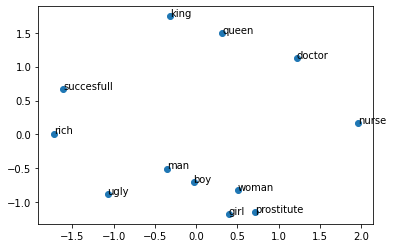

In [73]:
# the list of words we want to plot
words = ["man", "woman", "doctor", "nurse", "king", "queen", "boy", "girl","prostitute","rich","succesfull","ugly"]

# an empty list for vectors
X = []

# get vectors for subset of words
for word in words:
    X.append(model[word])

# Use PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# or try SVD - how are they different?
#svd = TruncatedSVD(n_components=2)
# fit_transform the initialized PCA model
#result = svd.fit_transform(X)

# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])

# for each word in the list of words
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

### Bonus tasks

If you run out of things to explore with these embeddings, try some of the following tasks:

[Easier]
- make new plots like those above but cleaner and more informative
- write a script which takes a list of words and produces the output above
  
[Very advanced]
- work through [this](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html) documentation which demonstrates how to train word embedding using ```pytorch```. Compare this to the training documentation [here](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) and think about how you would train a larger model on your own data.